# 不同大小的系统下，用量子卷积神经网络对量子多体基态进行分类
## 4 量子比特系统

当前进度为 10 验证集准确率为：0.57 loss 为：0.87170684
当前进度为 20 验证集准确率为：0.67 loss 为：0.4076001
当前进度为 30 验证集准确率为：0.82 loss 为：0.4300526
当前进度为 40 验证集准确率为：0.94 loss 为：0.43838817
当前进度为 50 验证集准确率为：0.97 loss 为：0.4536677


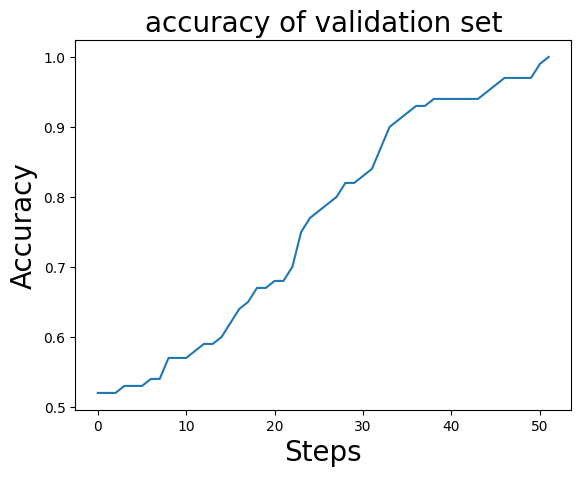

测试集上，预测准确率为： 1.0


In [27]:
from mindquantum import *
import numpy as np
import mindspore as ms
from mindspore import nn, ops, Tensor
from mindspore.nn import Adam, TrainOneStepCell, LossBase
import matplotlib.pyplot as plt
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(1)
import random
import copy 

def ham_layer(n_qubits=4, prefix='0'):
    circ_ = Circuit([ZZ(f'{0}').on([i, i+1]) for i in range(n_qubits-1)])
    circ_ += ZZ(f'{0}').on([n_qubits-1, 0])
    circ_ += Circuit([RX(f'{1}').on(i) for i in range(n_qubits)])
    circ_ += BarrierGate()
    circ_ = add_prefix(circ_, prefix)
    return circ_

def h_layer(n_qubits):
    circ_ = Circuit([H.on(i) for i in range(n_qubits)])
    circ_ += BarrierGate()
    return circ_

def conv(bit_up=0, bit_down=1, prefix='0'):
    _circ = Circuit()
    _circ += U3('theta00','phi00','lam00',bit_up)
    _circ += U3('theta01','phi01','lam01',bit_down)
    _circ += X.on(bit_down,bit_up)
    _circ += RY('theta10').on(bit_up)
    _circ += RZ('theta11').on(bit_down)
    _circ += X.on(bit_up,bit_down)
    _circ += RY('theta20').on(bit_up)
    _circ += X.on(bit_down,bit_up)
    _circ += U3('theta30','phi30','lam30',bit_up)
    _circ += U3('theta31','phi31','lam31',bit_down)
    _circ = add_prefix(_circ, 'prefix')
    return _circ

class MyLoss(LossBase):
    def __init__(self, reduction='mean'):
        super(MyLoss, self).__init__(reduction)
        self.cross_entropy = nn.SoftmaxCrossEntropyWithLogits(sparse=True)

    def construct(self, logits, label):
        out = self.cross_entropy(logits, label)
        return self.get_loss(out)

class MyWithLossCell(nn.Cell):
   def __init__(self, backbone, loss_fn):
       super(MyWithLossCell, self).__init__(auto_prefix=False)
       self._backbone = backbone
       self._loss_fn = loss_fn

   def construct(self, x, label):
       out = self._backbone(x)
       return self._loss_fn(out, label)

   @property
   def backbone_network(self):
       return self._backbone

n_qubits = 4

encoder = h_layer(n_qubits)
encoder += ham_layer(n_qubits, prefix='0')
encoder += ham_layer(n_qubits, prefix='1')
encoder = encoder.no_grad()
encoder.as_encoder()

ansatz = Circuit()
ansatz += conv(0,1,'0')
ansatz += conv(2,3,'1')
ansatz += conv(0,3,'2')
ansatz += conv(1,2,'3')
ansatz += conv(0,1,'4')
ansatz += conv(2,3,'5')
ansatz += conv(0,3,'6')
ansatz += conv(1,2,'7')
ansatz += conv(1,3,'8')
ansatz += conv(0,2,'9')
ansatz += conv(1,2,'10')
ansatz.as_ansatz()

circ = encoder + ansatz

ham = [Hamiltonian(QubitOperator('Z1')), Hamiltonian(QubitOperator('Z2'))]
sim = Simulator('projectq', circ.n_qubits)
grad_ops = sim.get_expectation_with_grad(ham, circ)
qnet = MQLayer(grad_ops)

loss = MyLoss()
net_with_criterion = MyWithLossCell(qnet, loss)
opti = Adam(qnet.trainable_params(), learning_rate=0.01)    
net = TrainOneStepCell(net_with_criterion, opti)

data_x_set = np.load('./src/4_qubit_train_x_set.npy', allow_pickle=True)
data_y_set = np.load('./src/4_qubit_train_y_set.npy', allow_pickle=True)
index = list(range(len(data_x_set)))
random.shuffle(index)

data_x_set = data_x_set[index]
data_y_set = data_y_set[index]

train_x_set = data_x_set[0:300]
val_x_set = data_x_set[300:400]
test_x_set = data_x_set[400:]

train_y_set = data_y_set[0:300]
val_y_set = data_y_set[300:400]
test_y_set = data_y_set[400:]

sim_2 = Simulator('projectq', circ.n_qubits)

batch_size = 5
loss_list = []
val_acc_list = []

j = 0
for i in range(100):
    j += 1
    index = np.random.randint(0, len(train_x_set), size=batch_size)
    x = train_x_set[index]
    y = train_y_set[index]
    loss = net(Tensor(x), Tensor(y, ms.int32))
    loss_list.append(loss.asnumpy())
    res_list = []
    for val_x, label in zip(val_x_set, val_y_set):
        sim_2.reset()
        params = np.append(val_x, qnet.weight.asnumpy())
        sim_2.apply_circuit(circ, params)
        expectation = [sim_2.get_expectation(ham[0]).real, sim_2.get_expectation(ham[1]).real]
        out = 0 if expectation[0] >= expectation[1] else 1
        res = 1 if label == out else 0
        res_list.append(res)
    acc = np.mean(res_list)
    val_acc_list.append(acc)
    if j % 10 == 0:
        print(f'当前进度为 {j}', f'验证集准确率为：{acc}',f'loss 为：{loss}')
    if acc == 1:
        params_best = copy.deepcopy(qnet.weight.asnumpy()) # 注意必须用 深拷贝，不然只是保存一个会随着训练不断变化的对象
        break
    
plt.figure()
plt.plot(val_acc_list) 
plt.title('accuracy of validation set', fontsize=20)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.savefig('./src/result_4_qubit.png')
plt.show()

test_acc_list = []
for test_x, label in zip(test_x_set, test_y_set):
    sim_2.reset()
    params = np.append(test_x, params_best)
    sim_2.apply_circuit(circ, params)
    expectation = [sim_2.get_expectation(ham[0]).real, sim_2.get_expectation(ham[1]).real]
    out = 0 if expectation[0] >= expectation[1] else 1
    res = 1 if label == out else 0
    test_acc_list.append(res)
acc = np.mean(test_acc_list)
print('测试集上，预测准确率为：', acc)

## 8 量子比特系统

当前进度为 10 验证集准确率为：0.52 loss 为：0.8162783
当前进度为 20 验证集准确率为：0.52 loss 为：0.49290872
当前进度为 30 验证集准确率为：0.7 loss 为：0.53818566
当前进度为 40 验证集准确率为：0.84 loss 为：0.42772475
当前进度为 50 验证集准确率为：0.93 loss 为：0.44071993
当前进度为 60 验证集准确率为：0.94 loss 为：0.39703387
当前进度为 70 验证集准确率为：0.94 loss 为：0.43514007
当前进度为 80 验证集准确率为：0.95 loss 为：0.39941853
当前进度为 90 验证集准确率为：0.94 loss 为：0.370883
当前进度为 100 验证集准确率为：0.94 loss 为：0.39488316
当前进度为 110 验证集准确率为：0.97 loss 为：0.34678575
当前进度为 120 验证集准确率为：0.98 loss 为：0.43523365
当前进度为 130 验证集准确率为：0.97 loss 为：0.4208228
当前进度为 140 验证集准确率为：0.95 loss 为：0.37535983
当前进度为 150 验证集准确率为：0.96 loss 为：0.43553686
当前进度为 160 验证集准确率为：0.95 loss 为：0.3913962
当前进度为 170 验证集准确率为：0.98 loss 为：0.44499034


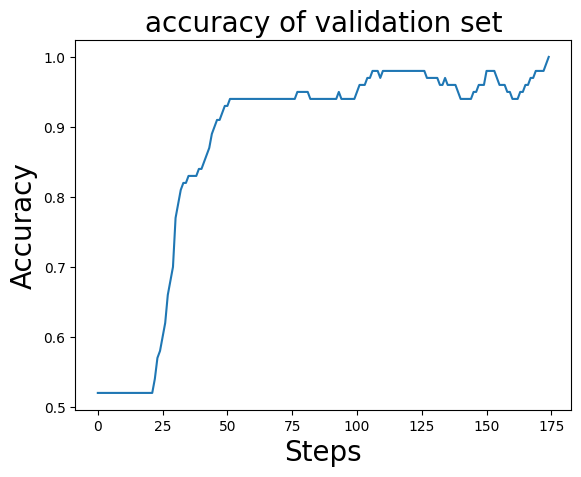

测试集上，预测准确率为： 1.0


In [29]:
from mindquantum import *
import numpy as np
import mindspore as ms
from mindspore import nn, ops, Tensor
from mindspore.nn import Adam, TrainOneStepCell, LossBase
import matplotlib.pyplot as plt
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(1)
import random
import copy 

def ham_layer(n_qubits=4, prefix='0'):
    circ_ = Circuit([ZZ(f'{0}').on([i, i+1]) for i in range(n_qubits-1)])
    circ_ += ZZ(f'{0}').on([n_qubits-1, 0])
    circ_ += Circuit([RX(f'{1}').on(i) for i in range(n_qubits)])
    circ_ += BarrierGate()
    circ_ = add_prefix(circ_, prefix)
    return circ_

def h_layer(n_qubits):
    circ_ = Circuit([H.on(i) for i in range(n_qubits)])
    circ_ += BarrierGate()
    return circ_

def conv(bit_up=0, bit_down=1, prefix='0'):
    _circ = Circuit()
    _circ += U3('theta00','phi00','lam00',bit_up)
    _circ += U3('theta01','phi01','lam01',bit_down)
    _circ += X.on(bit_down,bit_up)
    _circ += RY('theta10').on(bit_up)
    _circ += RZ('theta11').on(bit_down)
    _circ += X.on(bit_up,bit_down)
    _circ += RY('theta20').on(bit_up)
    _circ += X.on(bit_down,bit_up)
    _circ += U3('theta30','phi30','lam30',bit_up)
    _circ += U3('theta31','phi31','lam31',bit_down)
    _circ = add_prefix(_circ, 'prefix')
    return _circ


class MyLoss(LossBase):
    def __init__(self, reduction='mean'):
        super(MyLoss, self).__init__(reduction)
        self.cross_entropy = nn.SoftmaxCrossEntropyWithLogits(sparse=True)

    def construct(self, logits, label):
        out = self.cross_entropy(logits, label)
        return self.get_loss(out)

class MyWithLossCell(nn.Cell):
   def __init__(self, backbone, loss_fn):
       super(MyWithLossCell, self).__init__(auto_prefix=False)
       self._backbone = backbone
       self._loss_fn = loss_fn

   def construct(self, x, label):
       out = self._backbone(x)
       return self._loss_fn(out, label)

   @property
   def backbone_network(self):
       return self._backbone

n_qubits = 8

encoder = h_layer(n_qubits)
encoder += ham_layer(n_qubits, prefix='0')
encoder += ham_layer(n_qubits, prefix='1')
encoder += ham_layer(n_qubits, prefix='2')
encoder += ham_layer(n_qubits, prefix='3')
encoder = encoder.no_grad()
encoder.as_encoder()

ansatz = Circuit()
ansatz += conv(0,1,'0')
ansatz += conv(2,3,'1')
ansatz += conv(4,5,'2')
ansatz += conv(6,7,'3')
ansatz += conv(1,2,'4')
ansatz += conv(3,4,'5')
ansatz += conv(5,6,'6')
ansatz += conv(7,0,'7')
ansatz += conv(0,1,'8')
ansatz += conv(2,3,'9')
ansatz += conv(4,5,'10')
ansatz += conv(6,7,'11')
ansatz += conv(1,2,'12')
ansatz += conv(3,4,'13')
ansatz += conv(5,6,'14')
ansatz += conv(7,0,'15')
ansatz += conv(1,3,'16')
ansatz += conv(5,7,'17')
ansatz += conv(3,5,'18')
ansatz.as_ansatz()

circ = encoder + ansatz

ham = [Hamiltonian(QubitOperator('Z3')),Hamiltonian(QubitOperator('Z5'))]
sim = Simulator('projectq', circ.n_qubits)
grad_ops = sim.get_expectation_with_grad(ham, circ)
qnet = MQLayer(grad_ops)

loss = MyLoss()
net_with_criterion = MyWithLossCell(qnet, loss)
opti = Adam(qnet.trainable_params(), learning_rate=0.01)    
net = TrainOneStepCell(net_with_criterion, opti)

data_x_set = np.load('./src/8_qubit_train_x_set.npy', allow_pickle=True)
data_y_set = np.load('./src/8_qubit_train_y_set.npy', allow_pickle=True)

index = list(range(len(data_x_set)))
random.shuffle(index)

data_x_set = data_x_set[index]
data_y_set = data_y_set[index]

train_x_set = data_x_set[0:300]
val_x_set = data_x_set[300:400]
test_x_set = data_x_set[400:]

train_y_set = data_y_set[0:300]
val_y_set = data_y_set[300:400]
test_y_set = data_y_set[400:]

sim_2 = Simulator('projectq', circ.n_qubits)

batch_size = 5
loss_list = []
val_acc_list = []
params_best = []
j = 0
for i in range(1000):
    j += 1
    index = np.random.randint(0, len(train_x_set), size=batch_size)
    x = train_x_set[index]
    y = train_y_set[index]
    loss = net(Tensor(x), Tensor(y, ms.int32))
    loss_list.append(loss.asnumpy())
    res_list = []
    for val_x, label in zip(val_x_set, val_y_set):
        sim_2.reset()
        params = np.append(val_x, qnet.weight.asnumpy())
        sim_2.apply_circuit(circ, params)
        expectation = [sim_2.get_expectation(ham[0]).real, sim_2.get_expectation(ham[1]).real]
        out = 0 if expectation[0] >= expectation[1] else 1
        res = 1 if label == out else 0
        res_list.append(res)
    acc = np.mean(res_list)
    val_acc_list.append(acc)
    if j % 10 == 0:
        print(f'当前进度为 {j}', f'验证集准确率为：{acc}',f'loss 为：{loss}')
    if acc == 1:
        params_best.append(copy.deepcopy(qnet.weight.asnumpy())) # 注意必须用 深拷贝，不然只是保存一个会随着训练不断变化的对象
        break
    
plt.figure()
plt.plot(val_acc_list) # 画出训练过程中，验证集分类准确度的变化情况
plt.title('accuracy of validation set', fontsize=20)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.savefig('./src/result_8_qubit.png')
plt.show()

for params_b in params_best:
    test_acc_list = []
    for test_x, label in zip(test_x_set, test_y_set):
        sim_2.reset()
        params = np.append(test_x, params_b)
        sim_2.apply_circuit(circ, params)
        expectation = [sim_2.get_expectation(ham[0]).real, sim_2.get_expectation(ham[1]).real]
        out = 0 if expectation[0] >= expectation[1] else 1
        res = 1 if label == out else 0
        test_acc_list.append(res)
    acc = np.mean(test_acc_list)
    print('测试集上，预测准确率为：', acc)

当前进度为 0，验证集准确率为：0.51
当前进度为 10，验证集准确率为：0.97
当前进度为 20，验证集准确率为：0.81
当前进度为 30，验证集准确率为：0.93
当前进度为 40，验证集准确率为：0.91
当前进度为 50，验证集准确率为：0.94
当前进度为 60，验证集准确率为：0.94
当前进度为 70，验证集准确率为：0.93
当前进度为 80，验证集准确率为：0.98
当前进度为 90，验证集准确率为：0.95
当前进度为 100，验证集准确率为：0.95


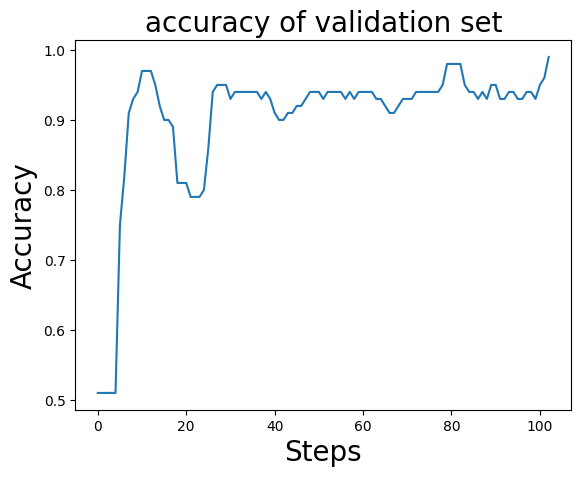

测试集上，预测准确率为：1.0


In [16]:
from mindquantum import *
import numpy as np
import mindspore as ms
from mindspore import nn, ops, Tensor
from mindspore.nn import Adam, TrainOneStepCell, LossBase
import matplotlib.pyplot as plt
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(1)
import random
import copy 

def ham_layer(n_qubits=4, prefix='0'):
    circ_ = Circuit([ZZ(f'{0}').on([i, i+1]) for i in range(n_qubits-1)])
    circ_ += ZZ(f'{0}').on([n_qubits-1, 0])
    circ_ += Circuit([RX(f'{1}').on(i) for i in range(n_qubits)])
    circ_ += BarrierGate()
    circ_ = add_prefix(circ_, prefix)
    return circ_

def h_layer(n_qubits):
    circ_ = Circuit([H.on(i) for i in range(n_qubits)])
    circ_ += BarrierGate()
    return circ_

def conv(bit_up=0, bit_down=1, prefix='0'):
    _circ = Circuit()
    _circ += U3('theta00','phi00','lam00',bit_up)
    _circ += U3('theta01','phi01','lam01',bit_down)
    _circ += X.on(bit_down,bit_up)
    _circ += RY('theta10').on(bit_up)
    _circ += RZ('theta11').on(bit_down)
    _circ += X.on(bit_up,bit_down)
    _circ += RY('theta20').on(bit_up)
    _circ += X.on(bit_down,bit_up)
    _circ += U3('theta30','phi30','lam30',bit_up)
    _circ += U3('theta31','phi31','lam31',bit_down)
    _circ = add_prefix(_circ, 'prefix')
    return _circ

class MyLoss(LossBase):
    def __init__(self, reduction='mean'):
        super(MyLoss, self).__init__(reduction)
        self.cross_entropy = nn.SoftmaxCrossEntropyWithLogits(sparse=True)

    def construct(self, logits, label):
        out = self.cross_entropy(logits, label)
        return self.get_loss(out)

class MyWithLossCell(nn.Cell):
   def __init__(self, backbone, loss_fn):
       super(MyWithLossCell, self).__init__(auto_prefix=False)
       self._backbone = backbone
       self._loss_fn = loss_fn

   def construct(self, x, label):
       out = self._backbone(x)
       return self._loss_fn(out, label)

   @property
   def backbone_network(self):
       return self._backbone

n_qubits = 12

encoder = h_layer(n_qubits)
encoder += ham_layer(n_qubits, prefix='0')
encoder += ham_layer(n_qubits, prefix='1')
encoder += ham_layer(n_qubits, prefix='2')
encoder += ham_layer(n_qubits, prefix='3')
encoder += ham_layer(n_qubits, prefix='4')
encoder += ham_layer(n_qubits, prefix='5')
encoder += ham_layer(n_qubits, prefix='6')
encoder += ham_layer(n_qubits, prefix='7')
encoder += ham_layer(n_qubits, prefix='8')
encoder += ham_layer(n_qubits, prefix='9')
encoder = encoder.no_grad()
encoder.as_encoder()

ansatz = Circuit()
ansatz += conv(0,1,'0')
ansatz += conv(2,3,'1')
ansatz += conv(4,5,'2')
ansatz += conv(6,7,'3')
ansatz += conv(8,9,'4')
ansatz += conv(10,11,'5')

ansatz += conv(1,2,'6')
ansatz += conv(3,4,'7')
ansatz += conv(5,6,'8')
ansatz += conv(7,8,'9')
ansatz += conv(9,10,'10')
ansatz += conv(11,0,'11')

ansatz += conv(0,1,'19')
ansatz += conv(2,3,'20')
ansatz += conv(4,5,'21')
ansatz += conv(6,7,'22')
ansatz += conv(8,9,'23')
ansatz += conv(10,11,'24')

ansatz += conv(1,2,'25')
ansatz += conv(3,4,'26')
ansatz += conv(5,6,'27')
ansatz += conv(7,8,'28')
ansatz += conv(9,10,'29')
ansatz += conv(11,0,'30')

ansatz += conv(0,2,'12')
ansatz += conv(3,5,'13')
ansatz += conv(6,8,'14')
ansatz += conv(9,11,'15')

ansatz += conv(2,5,'16')
ansatz += conv(8,11,'17')

ansatz += conv(5,8,'18')
ansatz.as_ansatz()

circ = encoder + ansatz

ham = [Hamiltonian(QubitOperator('Z5')),Hamiltonian(QubitOperator('Z8'))]
sim = Simulator('projectq', circ.n_qubits)
grad_ops = sim.get_expectation_with_grad(ham, circ)
qnet = MQLayer(grad_ops)

loss = MyLoss()
net_with_criterion = MyWithLossCell(qnet, loss)
opti = Adam(qnet.trainable_params(), learning_rate=0.1)    
net = TrainOneStepCell(net_with_criterion, opti)

data_x_set = np.load('./src/12_qubit_train_x_set.npy', allow_pickle=True)
data_y_set = np.load('./src/12_qubit_train_y_set.npy', allow_pickle=True)
index = list(range(len(data_x_set)))
random.shuffle(index)
data_x_set = data_x_set[index]
data_y_set = data_y_set[index]

train_x_set = data_x_set[0:300]
val_x_set = data_x_set[300:400]
test_x_set = data_x_set[400:]

train_y_set = data_y_set[0:300]
val_y_set = data_y_set[300:400]
test_y_set = data_y_set[400:]

sim_2 = Simulator('projectq', circ.n_qubits)

batch_size = 5
val_acc_list = []
for i in range(2000):
    index = np.random.randint(0, len(train_x_set), size=batch_size)
    x = train_x_set[index]
    y = train_y_set[index]
    loss = net(Tensor(x), Tensor(y, ms.int32))
    res_list = []
    for val_x, label in zip(val_x_set, val_y_set):
        sim_2.reset()
        params = np.append(val_x, qnet.weight.asnumpy())
        sim_2.apply_circuit(circ, params)
        expectation = [sim_2.get_expectation(ham[0]).real, sim_2.get_expectation(ham[1]).real]
        out = 0 if expectation[0] >= expectation[1] else 1
        res = 1 if label == out else 0
        res_list.append(res)
    acc = np.mean(res_list)
    val_acc_list.append(acc)
    if i % 10 == 0:
        print(f'当前进度为 {i}，验证集准确率为：{acc}')
    if acc >= 0.99:
        params_best = copy.deepcopy(qnet.weight.asnumpy()) # 注意必须用 深拷贝，不然只是保存一个会随着训练不断变化的对象
        break
    
    
plt.figure()
plt.plot(val_acc_list) # 画出训练过程中，验证集分类准确度的变化情况
plt.title('accuracy of validation set', fontsize=20)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.savefig('./src/result_12_qubit.png')
plt.show()

test_acc_list = []
for test_x, label in zip(test_x_set, test_y_set):
    sim_2.reset()
    params = np.append(test_x, params_best)
    sim_2.apply_circuit(circ, params)
    expectation = [sim_2.get_expectation(ham[0]).real, sim_2.get_expectation(ham[1]).real]
    out = 0 if expectation[0] >= expectation[1] else 1
    res = 1 if label == out else 0
    test_acc_list.append(res)
acc = np.mean(test_acc_list)
print(f'测试集上，预测准确率为：{acc}')